
Прогнозирование с помощью  Auto-Arima



In [ ]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy~=1.19.0 in c:\users\my\anaconda3\lib\site-packages (from pmdarima) (1.19.2)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import pmdarima as pm

In [ ]:
df = pd.read_csv('_lab_9_11/wine_Austral2.dat', sep = "\t")
df

,fort,dry,sweet,red,rose,spark,total,year_,month_,date_
0,2585,1954,85,464,112,1686,15136,1980,1,JAN 1980
1,3368,2302,89,675,118,1591,16733,1980,2,FEB 1980
2,3210,3054,109,703,129,2304,20016,1980,3,MAR 1980
3,3111,2414,95,887,99,1712,17708,1980,4,APR 1980
4,3756,2226,91,1139,116,1471,18019,1980,5,MAY 1980
...,...,...,...,...,...,...,...,...,...,...
169,1568,3685,280,1728,35,1968,22784,1994,2,FEB 1994
170,1965,3754,187,2201,42,1720,23565,1994,3,MAR 1994
171,2659,3708,279,2455,48,1725,26323,1994,4,APR 1994
172,2354,3210,193,2204,44,1674,23779,1994,5,MAY 1994


Прогнозируем розовое вино.

In [ ]:
df_1 = df['rose']
df_1

0      112
1      118
2      129
3       99
4      116
      ... 
169     35
170     42
171     48
172     44
173     45
Name: rose, Length: 174, dtype: int64

In [ ]:
horizon = 8 #Количество месяцев для прогноза

Оценим наши данные с помощью графика

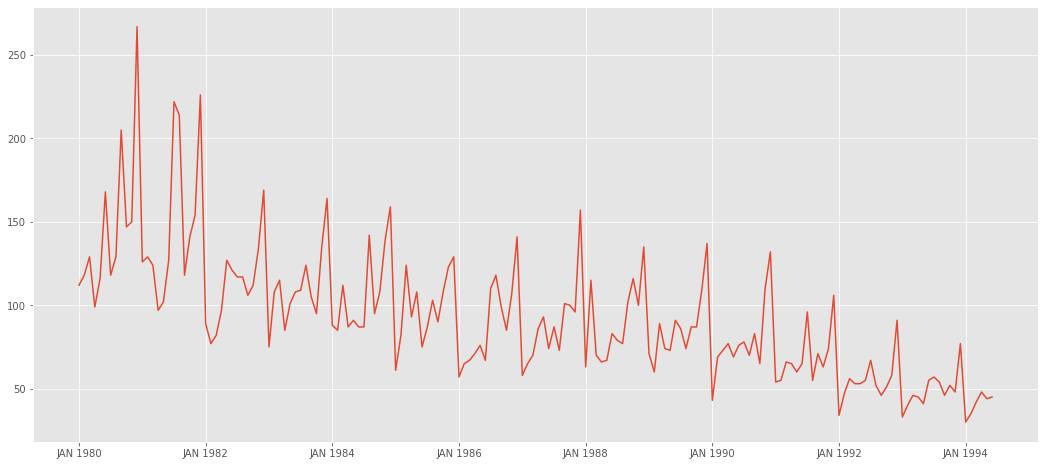

In [ ]:
df_2 = df['date_']
y_pos = np.arange(0, 174, 24)
plt.figure(figsize=(18, 8))

df_1.plot()

# Добавляем даты на график
plt.xticks(y_pos, df_2[y_pos])

plt.show()

1.  У временного ряда линейный тренд. <br>

2.  У временного ряда мультипликативная сезонность. <br>

3.  Ряд не меняет свой характер. <br>

4.  У ряда нет выбросов (высокие началные значения - результат мультпликативности). <br>

5.  У ряда нет пропусков. <br>


###  Приступаем к прогнозированию


In [ ]:
# период сезонных отклонений
seas_period_ = 12

Сезонность мультпликативная, поэтому работаем с логарифмами

In [ ]:
df_1 = np.log10(df['rose'])
df_1

0      2.049218
1      2.071882
2      2.110590
3      1.995635
4      2.064458
         ...   
169    1.544068
170    1.623249
171    1.681241
172    1.643453
173    1.653213
Name: rose, Length: 174, dtype: float64

In [ ]:
#НЕОБХОДИМО ДЛЯ ОЦЕНКИ КАЧЕСТВА МОДЕЛИ
#Количество месяцев для тренировки
train_length = len(df_1) - horizon
#Делим на обучающее и тестовое множества 
df_train = df_1.iloc[0:train_length]
df_test = df_1.iloc[train_length:len(df_1)]

Ряд логарифмов 

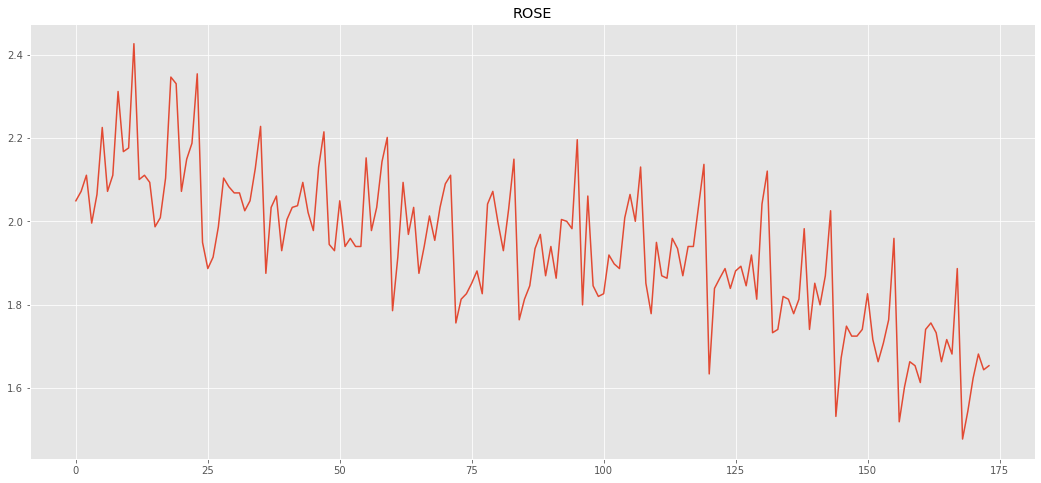

In [ ]:
plt.figure(figsize=(18, 8))
df_1.plot()
plt.title(u'ROSE')
plt.show()

Предсказываем значения для тренировочного набора данных

In [ ]:
model = pm.auto_arima(df_train, m = seas_period_,seasonal=True, scoring='mse')

In [ ]:
model.fit(df_train)

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

Оценим качество работы модели с помощью графика 

In [ ]:
forecast = model.predict(n_periods=horizon)
forecast

array([1.77539888, 1.89837389, 1.51399961, 1.59868549, 1.64477746,
       1.62809153, 1.61942607, 1.66039164])

In [ ]:
10**forecast

array([59.62094774, 79.13596356, 32.65875402, 39.69040098, 44.13442404,
       42.47090638, 41.63188491, 45.75005709])

In [ ]:
valid = range(len(df_train), len(df_1), 1) 
valid

range(166, 174)

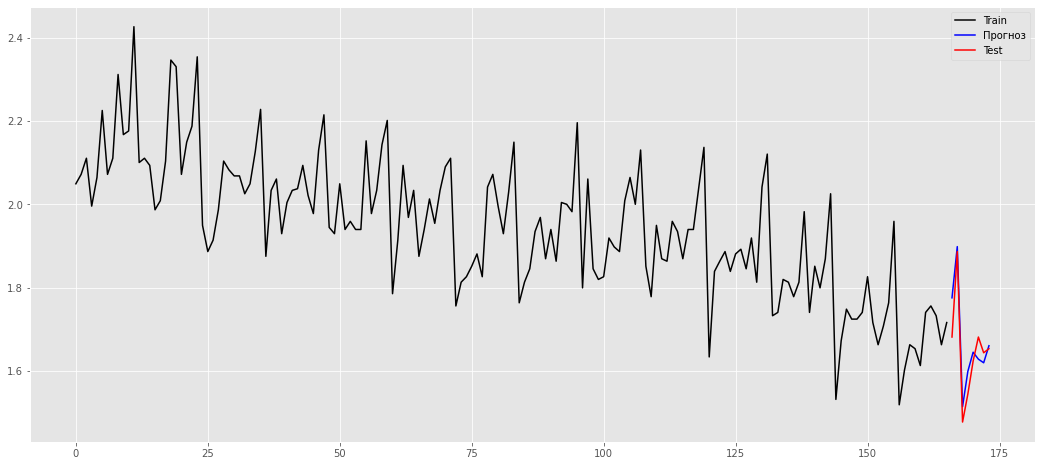

In [ ]:
#   Проверяем качество прогноза для логарифмов
#   Строим графики

forecast_1 = pd.DataFrame(forecast, index = valid, columns=['Prediction'])
plt.figure(figsize=(18, 8))

#  график ряда логарифмов
plt.plot(df_train, label='Train', c = 'black')
#  график прогноза для логарифмов
plt.plot(forecast_1, label='Прогноз', c = 'blue')

plt.plot(df_test, label='Test', c = 'red')
plt.legend(loc='best')


plt.show()

Оценим качество работы модели с помощью оценки ошибки прогноза

In [ ]:
forecast_2 = 10**forecast_1.to_numpy().flatten()
df_test_1 = 10**df_test.to_numpy()

In [ ]:
#   Mean Absolute Percentage Error
MAPE_ARIMA = np.mean(np.abs((forecast_2 - df_test_1)/df_test_1))*100
print("MAPE для ARIMA = ", MAPE_ARIMA, '%')

MAPE для ARIMA =  9.11221572891638 %


Результат аналогичен экспоненциальному сглаживанию. Не считаю данный показатель высоким, модель меня устраивает

Спрогнозируем 8 месяцев с помощью полученной модели. Для этого необходимо перенатренировать модель на полном наборе данных

In [ ]:
valid1 = range(len(df_1), len(df_1)+horizon, 1) 
valid1

range(174, 182)

In [ ]:
model_1 = model
model_1.fit(df_1)

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

Результат

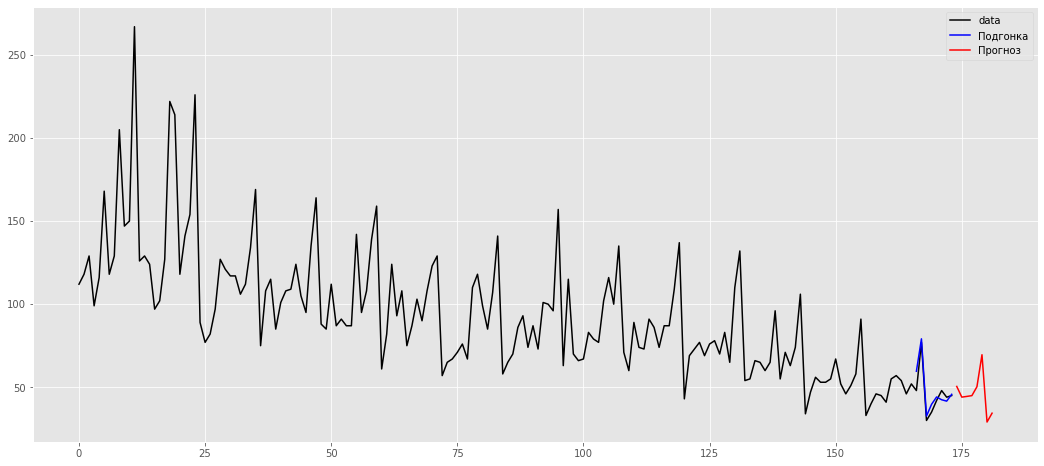

In [ ]:
forecast_1 = pd.DataFrame(forecast, index = valid, columns=['Prediction'])
plt.figure(figsize=(18, 8))

#  график ряда логарифмов
plt.plot(10**df_1, label='data', c = 'black')
#  график прогноза для логарифмов
plt.plot(10**forecast_1, label='Подгонка', c = 'blue')

plt.plot(valid1, 10**model_1.predict(n_periods = horizon), label='Прогноз', c = 'red')
plt.legend(loc='best')


plt.show()